### Easy 21 Assignment
http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf

#### Part 1: Implementation of Easy 21

In [60]:
import numpy as np

#doing the convenience functions here
#not doing the wrapper as that will differ depending on the algorithm, control policy etc

new_state = (-19,-19)
bust_value = 0 #treating all busts the same

def get_initial_state():
    player_state = np.random.randint(1,11)
    dealer_state = np.random.randint(1,11)
    init_state = (player_state,dealer_state)
    return init_state

def draw_card():
    #infinite deck w/ replacement, values 1-10
    #2/3 black (positive), 1/3 red (negative)
    card = np.random.randint(1,11)
    if np.random.randint(0,3) == 0:
        card *= -1
    return card

#this probably not necessary, next_state is redundant if it's a bust as passing along a 'done' variable
#treating all busts as similar states
def cap_state(value,card):
    new_value = value+card
    if new_value < 1:
        new_value = bust_value
    elif new_value > 21:
        new_value = bust_value 
    
    return new_value
    
#returns next_state,action,reward,state,done (1/0 for done or not)
def step(state,action):
    if state == new_state:
        state = get_initial_state()
        
    if action == 'hit':
        card = draw_card()
        next_state = ( cap_state(state[0],card),state[1]) 
        if next_state[0] == bust_value:
            return (next_state,action,-1.,state,1)
        else:
            return (next_state,action,0,state,0)
    else: #stick
        dealer_value = state[1]
        player_value = state[0]
        while True:
            card = draw_card()
            dealer_value += card
            
            if dealer_value > 21 or dealer_value < 1:
                reward = 1.
                break
            elif dealer_value >= 17:
                if dealer_value > player_value:
                    reward = -1.
                elif dealer_value == player_value:
                    reward = 0.
                else:
                    reward = 1.
                break
                
        next_state = (player_value,cap_state(dealer_value,0))
        return (next_state,action,reward,state,1)


In [61]:
#testing step
# state = (18,10)
# state = new_state
# (state,action,reward,next_state,done) = step( state,'stick')
# print(state,action,reward,next_state,done)

#### Part 2: Monte-Carlo Control in Easy 21

Says to initialize the value function to 0 but then has the optimal value function being based on the max Q(S,A). Going to initialize the the value function to 0 and implement finding the optimal value function based on max Q(S,A) but not going to update the value function until the end, instead going to update Q(S,A) after runs then at the end update the value function.<br>

Issue: so the alpha initialization seems to start with alpha being 1, thus pushing the reward to -1 or 1, but won't that lead to faulty values? Values will become less than -1 and greater than 1 even though nothing should be past 1 or -1. I can either change it to 0.5 or update Q with prior Q value altered by the reward ie doing q(s,a) = q(s,a) + alpha * (reward-q(s,a)). Doing the latter.

In [200]:
def init_value_function(value,player_range_min,player_range_max,dealer_range_min,dealer_range_max):
    ret_dict = {}
    for i in range(player_range_min,player_range_max+1):
        for j in range(dealer_range_min,dealer_range_max+1):
            ret_dict[(i,j)] = value
    return ret_dict

value_dict = init_value_function(0.,1,21,1,10)
#print(value_dict)

def get_optimal_value_function(v_dict,q_dict,actions):
    for key in v_dict:
        for j in actions:
            if q_dict[(key,j)] > v_dict[key]:
                v_dict[key] = q_dict[(key,j)]
    return v_dict

action_space = ['hit','stick']

#define the q_dict
def init_q_dict(value,actions,player_range_min,player_range_max,dealer_range_min,dealer_range_max):
    ret_dict = {}
    for i in range(player_range_min,player_range_max+1):
        for j in range(dealer_range_min,dealer_range_max+1):
            for k in actions:
                ret_dict[((i,j),k)] = value
    return ret_dict

qsa_dict = init_q_dict(0,action_space,1,21,1,10)

#update q dict with reward
#don't need to worry about next_state since MC waits until end of action
def update_q_dict(q_dict,reward,s_list,a_list,alpha_list):
    for st,at,alpha_t in zip(s_list,a_list,alpha_list):
        #print("q_dict before", q_dict[(st,at)] )
        q_dict[(st,at)] = q_dict[(st,at)] + alpha_t * ( reward - q_dict[(st,at)] ) #not sure if this is proper update 
        #print("alpha_t, reward = ",alpha_t * reward)
        #print("q_dict after", q_dict[(st,at)] )
        
    return q_dict
    

def get_greedy_action(q_dict,s,a_space):
    if q_dict[(s,a_space[0])] > q_dict[(s,a_space[1])]:
        return a_space[0]
    elif q_dict[(s,a_space[0])] < q_dict[(s,a_space[1])]:
        return a_space[1]
    else:
        return a_space[np.random.randint(0,2)]

#register (increment the state counter) and get the count of the state
#need this as epislon greedy changes by how often the state has been visited
def register_and_get_state(s_dict,s):
    ret_value = s_dict[s]
    s_dict[s] += 1
    return ret_value

state_count_dict = init_value_function(0.,1,21,1,10)

#starting at 0
# If I start at 0, then either divide by 0 or first alpha is 1, which can push values    
def register_and_get_alpha(a_dict,s,a):
    a_dict[(s,a)] += 1.
    ret_value = a_dict[(s,a)]
    return 1./ret_value

alpha_dict = init_q_dict(0,action_space,1,21,1,10) 

In [201]:
episodes = 1000000
N0 = 100.

for i in range(episodes):
    state_list = []
    alpha_list = []
    action_list = []
    state = get_initial_state()
    while True:
        state_count = register_and_get_state(state_count_dict,state)
        epsilon = N0/(N0 + state_count)

        if np.random.rand() >= epsilon:
            #choose greedy action
            action = get_greedy_action(qsa_dict,state,action_space)
        else:
            #choose random action
            action = action_space[np.random.randint(0,len(action_space))]
        
        #only need alpha if done, but have to register on every action
        alpha = register_and_get_alpha(alpha_dict,state,action)
        
        state_list.append(state)
        alpha_list.append(alpha)
        action_list.append(action)
        
        #input_state,action,reward,next_state,done (1/0 for done or not)
        next_state,action,reward,_,done = step(state,action)

        #print(i, state,action,reward,next_state,done,alpha)
        if done:
            qsa_dict = update_q_dict(qsa_dict,reward,state_list,action_list,alpha_list)
            #print(qsa_dict[(state,action)])
            break
        else:
            state = next_state

(21, 10) (21, 10) (21, 10)


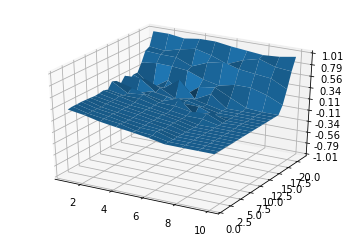

In [202]:
#the plot
value_dict = get_optimal_value_function(value_dict,qsa_dict,action_space)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.arange(1,11,1)
#X = np.arange(1,11,1)
Y = np.arange(1,22,1)
Z = []
# for i in X:
#     for j in Y:
#         Z.append(value_dict[(j,i)])
for i in Y:
    for j in X:
        Z.append(value_dict[(i,j)])

#print(Z)
# X = np.arange(1,11,1)
# Y = np.arange(1,11,1)
# Z = np.random.rand(10)
    
X, Y = np.meshgrid(X, Y)
Z = np.asarray(Z)
Z = np.reshape(Z,(21,10))

#print(X,len(X))
#print(Z,len(Z))

print(np.shape(X),np.shape(Y),np.shape(Z))

# Plot the surface.
# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)

surf = ax.plot_surface(X, Y, Z )
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#print(Z)
#print(value_dict[(1,2)])

In [180]:
# print(state,action,reward,next_state,done)
# for k, v in qsa_dict.items():
#     if v != 0.0:
#         print(k,v)

In [193]:
import collections

od = collections.OrderedDict(sorted(qsa_dict.items()))
for k, v in od.items(): 
    print(k, v)

((1, 1), 'hit') -0.3333333333333333
((1, 1), 'stick') 0.3289473684210521
((1, 2), 'hit') -0.2033898305084746
((1, 2), 'stick') 0.27491785323110596
((1, 3), 'hit') -0.16535433070866135
((1, 3), 'stick') 0.1971830985915493
((1, 4), 'hit') -0.3237410071942445
((1, 4), 'stick') 0.16720604099244868
((1, 5), 'hit') -0.29230769230769227
((1, 5), 'stick') 0.0901098901098902
((1, 6), 'hit') -0.3953488372093025
((1, 6), 'stick') 0.06448311156601853
((1, 7), 'hit') -0.5041322314049587
((1, 7), 'stick') -0.022269353128313907
((1, 8), 'hit') -0.5041322314049587
((1, 8), 'stick') -0.056105610561056084
((1, 9), 'hit') -0.455621301775148
((1, 9), 'stick') -0.1413934426229507
((1, 10), 'hit') -0.634920634920635
((1, 10), 'stick') -0.26361655773420456
((2, 1), 'hit') -0.07246376811594206
((2, 1), 'stick') 0.3251121076233188
((2, 2), 'hit') -0.12605042016806722
((2, 2), 'stick') 0.28421052631578964
((2, 3), 'hit') -0.1964285714285714
((2, 3), 'stick') 0.19609967497291425
((2, 4), 'hit') -0.30935251798561

In [195]:
value_dict = get_optimal_value_function(value_dict,qsa_dict,action_space)

import operator
sorted_value = sorted(value_dict.items(),key=operator.itemgetter(1))
print(sorted_value)
# x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
# sorted_x = sorted(x.items(), key=operator.itemgetter(1))

[((6, 9), 0.0), ((16, 9), 0.0), ((3, 7), 0.0), ((5, 8), 0.0), ((10, 8), 0.0), ((6, 7), 0.0), ((10, 7), 0.0), ((6, 10), 0.0), ((13, 7), 0.0), ((4, 10), 0.0), ((13, 10), 0.0), ((9, 9), 0.0), ((7, 8), 0.0), ((14, 8), 0.0), ((12, 8), 0.0), ((8, 9), 0.0), ((16, 7), 0.0), ((11, 10), 0.0), ((16, 10), 0.0), ((1, 10), 0.0), ((10, 9), 0.0), ((11, 9), 0.0), ((15, 10), 0.0), ((2, 7), 0.0), ((5, 10), 0.0), ((10, 10), 0.0), ((5, 7), 0.0), ((15, 9), 0.0), ((13, 9), 0.0), ((4, 8), 0.0), ((2, 8), 0.0), ((9, 8), 0.0), ((14, 9), 0.0), ((12, 9), 0.0), ((3, 10), 0.0), ((8, 10), 0.0), ((17, 5), 0.0), ((14, 10), 0.0), ((17, 10), 0.0), ((15, 3), 0.0), ((7, 7), 0.0), ((3, 9), 0.0), ((1, 9), 0.0), ((8, 7), 0.0), ((6, 5), 0.0), ((11, 7), 0.0), ((6, 8), 0.0), ((11, 8), 0.0), ((16, 8), 0.0), ((15, 6), 0.0), ((1, 7), 0.0), ((5, 9), 0.0), ((4, 7), 0.0), ((17, 3), 0.0), ((13, 8), 0.0), ((4, 9), 0.0), ((2, 9), 0.0), ((7, 10), 0.0), ((12, 10), 0.0), ((2, 10), 0.0), ((9, 10), 0.0), ((7, 9), 0.0), ((17, 9), 0.0), ((3, 8)

### Part 3: TD Learning in Easy21

Relies on values found by MC in last section being optimal. <br>

Issue: I don't think I'm visiting the states enough to come up with values that converge. There are 420 state, action combos and I'm only doing 1000 episodes.

In [324]:
#line 3500 ish has notes and the algorithm
lambda_list = [0., 0.1, 0.2, 0.3,0.4,0.5,
               0.6,0.7,0.8,0.9, 1.]
#lambda_list = [0.,0.5,1]
lambda_len = len(lambda_list)

sarsa_q_dict = []
sarsa_s_count_dict = []
sarsa_alpha_dict = []

for i in range(lambda_len):
    sarsa_q_dict.append(init_q_dict(0,action_space,1,21,1,10))
    sarsa_s_count_dict.append(init_value_function(0,1,21,1,10))
    sarsa_alpha_dict.append(init_q_dict(0,action_space,1,21,1,10))
    
# state_count_dict = init_value_function(0.,1,21,1,10)
# alpha_dict = init_q_dict(0,action_space,1,21,1,10)
#print(len(sarsa_q))

lambda_0_lc = []
lambda_1_lc = []

def get_mean_squared_error(l_q_dict,mc_q_dict,actions,player_range_min,player_range_max,dealer_range_min,dealer_range_max):
    ret_value = 0
    for i in range(player_range_min,player_range_max+1):
        for j in range(dealer_range_min,dealer_range_max+1):
            for k in actions:
                ret_value += ( l_q_dict[((i,j),k)] - mc_q_dict[((i,j),k)] )**2
    return ret_value

def get_greedy_action_value(q_dict,s,a_space):
    #episode can be done but still need to update the eligibility traces
        #in which case, neither action matters but the greedy value is reward
        
    dealer_value = s[1]
    player_value = s[0]
    end_state_value = 0. #I think this is correct, if you do 1 or -1 then you double count the rewards
    #print(dealer_value)
    if player_value == 0:
        return a_space[np.random.randint(0,2)],-1. * end_state_value
    elif dealer_value == 0:
        return a_space[np.random.randint(0,2)], 1. * end_state_value
    elif dealer_value >= 17:
        #print('test')
        if dealer_value > player_value:
            return a_space[np.random.randint(0,2)],-1. * end_state_value
        elif dealer_value < player_value:
            return a_space[np.random.randint(0,2)], 1. * end_state_value
        else: #draw
            return a_space[np.random.randint(0,2)], 0.
    
    if q_dict[(s,a_space[0])] > q_dict[(s,a_space[1])]:
        return a_space[0], q_dict[(s,a_space[0])]
    elif q_dict[(s,a_space[0])] < q_dict[(s,a_space[1])]:
        return a_space[1], q_dict[(s,a_space[1])]
    else:
        return a_space[np.random.randint(0,2)],q_dict[(s,a_space[0])]
    

In [325]:
episodes = 10000 #1000 #1000 might be too low
N0 = 100
#iterate over every episode
#in every episode, go through each lambda

for i in range(episodes):
    for j in range(lambda_len):
        #init eligibility dict
        eli_dict = {} #doing .get and default to 0 #init_q_dict(0,action_space,1,21,1,10)
        #get initial state
        state = get_initial_state()
        
        while True:
            #same exploration as last time
            state_count = register_and_get_state(sarsa_s_count_dict[j],state)
            epsilon = N0/(N0 + state_count)

            if np.random.rand() <= epsilon:
                #choose greedy action
                action = get_greedy_action(sarsa_q_dict[j],state,action_space)
            else:
                #choose random action
                action = action_space[np.random.randint(0,len(action_space))]

            #next_state,action,reward,state,done (1/0 for done or not)
            next_state,action,reward,_,done = step(state,action)

            greedy_action,greedy_value = get_greedy_action_value(sarsa_q_dict[j],next_state,action_space)
            
            delta = reward + greedy_value - sarsa_q_dict[j][(state,action)] #gamma = 1.
            #print(delta)
            eli_dict[(state,action)] = eli_dict.get((state,action),0.) + 1
            
            alpha = register_and_get_alpha(sarsa_alpha_dict[j],state,action)
            
            for k in range(1,22):
                for l in range(1,11):
                    for m in action_space:
                        temp_key = ((k,l),m)
                        temp_trace = eli_dict.get(temp_key,0.)
                        if temp_trace != 0:
#                             if i == 5:
#                                 print(j,alpha,delta,eli_dict[((k,l),m)])
                            sarsa_q_dict[j][temp_key] += alpha*delta*temp_trace
                            eli_dict[temp_key] *= lambda_list[j] #no gamma
            
            if done:
                if j == 0:
                    lambda_0_lc.append(
                        get_mean_squared_error(sarsa_q_dict[j],qsa_dict,action_space,1,21,1,10)
                    )
                elif j == 10:
                    lambda_1_lc.append(
                        get_mean_squared_error(sarsa_q_dict[j],qsa_dict,action_space,1,21,1,10)
                    )
                break
            else:
                state = next_state

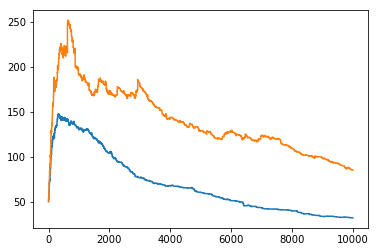

In [326]:
#assuming MC Q(S,A) are the optimal
#plot the learning curves for lambda 0 and lambda 1

# plt.plot(lambda_0_lc,'.')
# plt.plot(lambda_1_lc,'.')
plt.plot(lambda_0_lc)
plt.plot(lambda_1_lc)
plt.show()

# import matplotlib.pyplot as plt
# plt.plot(g_sa_avg,'.') #blue
# plt.plot(g_css_avg,'.') #orange
# plt.plot(e_sa_avg,'.') #green
# plt.plot(e_css_avg,'.') #red
# plt.show()

[31.81525487282098, 37.953464146864725, 43.015207314762165, 43.314398033771475, 55.423612257295204, 50.38218816535615, 53.56424486986432, 64.80444147632677, 76.7078375536174, 76.59901827190376, 84.97514220901157]


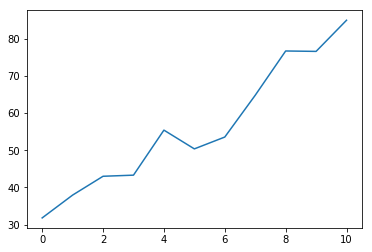

In [327]:
#plot the mean squared errors for lamba vs. MC Q(S,A)
lambda_mse = []
for i in range(lambda_len):
    lambda_mse.append(get_mean_squared_error(sarsa_q_dict[i],qsa_dict,action_space,1,21,1,10))

print(lambda_mse)
plt.plot(lambda_mse)
plt.show()

In [328]:
#print(lambda_0_lc,lambda_1_lc)

In [329]:
#as you can see, not visiting some of the states that much. No wonder that the MSE is so high
import collections

od = collections.OrderedDict(sorted(sarsa_q_dict[1].items()))
for k, v in od.items(): 
    print(sarsa_s_count_dict[1][k[0]], k, v, )

    

111 ((1, 1), 'hit') -0.2413813850631332
111 ((1, 1), 'stick') 0.34736842105263155
119 ((1, 2), 'hit') -0.1273979084002416
119 ((1, 2), 'stick') 0.20454545454545459
126 ((1, 3), 'hit') -0.1434224827684278
126 ((1, 3), 'stick') 0.27058823529411774
96 ((1, 4), 'hit') -0.1209208786013213
96 ((1, 4), 'stick') -0.15384615384615388
115 ((1, 5), 'hit') -0.21413715067314643
115 ((1, 5), 'stick') 0.18072289156626506
110 ((1, 6), 'hit') -0.4758799986408145
110 ((1, 6), 'stick') 0.08695652173913043
105 ((1, 7), 'hit') -0.2941496267315553
105 ((1, 7), 'stick') -0.02272727272727277
119 ((1, 8), 'hit') -0.34536579209275714
119 ((1, 8), 'stick') -0.12871287128712866
136 ((1, 9), 'hit') -0.27102979560697266
136 ((1, 9), 'stick') -0.11111111111111108
102 ((1, 10), 'hit') -0.4852058480571326
102 ((1, 10), 'stick') -0.24137931034482757
116 ((2, 1), 'hit') -0.24462198522192272
116 ((2, 1), 'stick') 0.3195876288659794
122 ((2, 2), 'hit') -0.1898600499682239
122 ((2, 2), 'stick') 0.26027397260273977
129 ((2,

In [330]:
# od = collections.OrderedDict(sorted(sarsa_s_count_dict[1].items()))
# for k, v in od.items(): 
#     print(k, v)

In [333]:
test  = ((4,3),"hit")
print(test[0][0],test[0][1],test[1])

test = {}
test.append()

4 3 hit


### Part 4: Linear Function Approximation in Easy21

I believe that the keys for the eligibility trace are also the linear function approximation keys.

In [446]:
#overlapping intervals
#dealer(s) = {[1, 4], [4, 7], [7, 10]}
#player(s) = {[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]}
#a = {hit, stick}

def init_lfa_dict(v):
    ret_dict = {}
    for i in range(6):
        for j in range(3):
            for k in action_space:
                ret_dict[((i,j),k)] = v
    return ret_dict
                

player_range_mins = [1,4,7,10,13,16]
player_range_maxes = [6,9,12,15,18,21]
player_range_len = len(player_range_mins)

def get_lfa_keys(sa):
    ret_keys = []
    player_keys = []
    dealer_keys = []
    player_s = sa[0][0]
    dealer_s = sa[0][1]
    a = sa[1]
    #print(player_s,dealer_s)
    
    for i in range(player_range_len):
        #print(i,player_s,player_range_mins[i])
        if player_s >= player_range_mins[i] and player_s <= player_range_maxes[i]:
            player_keys.append(i)
#             print("passed test one",i,player_s,player_range_mins[i+1])
#             if i < 5 and player_s >= player_range_mins[i+1]:
#                 print("passed test two")
#                 player_keys.append(i+1)

    #not doing overlapping for dealer
    if dealer_s >= 1 and dealer_s <= 4:
        dealer_keys.append(0)
    elif dealer_s > 4 and dealer_s <= 7:
        dealer_keys.append(1)
    elif dealer_s > 7 and dealer_s <= 10:
        dealer_keys.append(2)
        
    for i in player_keys:
        for j in dealer_keys:
            ret_keys.append(((i,j),a))
            
    return ret_keys

#line 3500 ish has notes and the algorithm
lambda_list = [0., 0.1, 0.2, 0.3,0.4,0.5,
               0.6,0.7,0.8,0.9, 1.]
#lambda_list = [0.,0.5,1]
lambda_len = len(lambda_list)

lfa_q_dict = []

for i in range(lambda_len):
    lfa_q_dict.append(init_lfa_dict(0.))
    
#print(len(lfa_q_dict))
#print(len(lfa_q_dict[0]))

lfa_lambda_0_lc = []
lfa_lambda_1_lc = []

def get_greedy_action_value_lfa(q_dict,s,a_space):
    #episode can be done but still need to update the eligibility traces
        #in which case, neither action matters but the greedy value is reward
    dealer_value = s[1]
    player_value = s[0]
    end_state_value = 0. #I think this is correct, if you do 1 or -1 then you double count the rewards
    #print(dealer_value)
    if player_value == 0:
        return a_space[np.random.randint(0,2)],-1. * end_state_value
    elif dealer_value == 0:
        return a_space[np.random.randint(0,2)], 1. * end_state_value
    elif dealer_value >= 17:
        #print('test')
        if dealer_value > player_value:
            return a_space[np.random.randint(0,2)],-1. * end_state_value
        elif dealer_value < player_value:
            return a_space[np.random.randint(0,2)], 1. * end_state_value
        else: #draw
            return a_space[np.random.randint(0,2)], 0.
    
    temp_keys = get_lfa_keys((state,a_space[0]))
    temp_keys_2 = get_lfa_keys((state,a_space[1]))
    #print(temp_keys,temp_keys_2)
    temp_keys = temp_keys + temp_keys_2
    
    #print( temp_keys)
    #print(temp_keys[0][1])
    
    greedy_action = temp_keys[0][1]
    greedy_value = q_dict[temp_keys[0]]
    greedy_list = []
    greedy_list.append(greedy_action)
    
    for i in range(1,len(temp_keys)):
        temp_value = q_dict[temp_keys[i]]
        if temp_value > greedy_value:
            greedy_value = temp_value
            greedy_action = temp_keys[i][1]
            greedy_list = []
            greedy_list.append(greedy_action)
        elif temp_value == greedy_value:
            greedy_list.append(temp_keys[i][1])
    
    #print(greedy_list)
    #print(np.random.randint(0,len(greedy_list),100))
    #in case of two equal actions, randomly choose
    if len(greedy_list) > 1:
        x = np.random.randint(0,len(greedy_list))
        #print(x)
        greedy_action = greedy_list[x]
        #greedy_action = greedy_list[np.random.randint(0,len(greedy_list))]
        
    return greedy_action, greedy_value


#need to do it a bit differently as it's not a one to one comparison
#for every interval in the MC state space, compare it to the lfa equivalent
    #for overlapping intervals, average the MSE
def get_lfa_mean_squared_error(l_q_dict,mc_q_dict,actions,player_range_min,player_range_max,dealer_range_min,dealer_range_max):
    ret_value = 0
    for i in range(player_range_min,player_range_max+1):
        for j in range(dealer_range_min,dealer_range_max+1):
            for k in actions:
                #getting the mean of possible lfa values
                lfa_keys = get_lfa_keys(((i,j),k))
                if len(lfa_keys) > 1:
                    lfa_values = []
                    for l in lfa_keys:
                        lfa_values.append(l_q_dict[l])
                    lfa_mean_value = np.mean(lfa_values)
                else:
                    lfa_mean_value = l_q_dict[lfa_keys[0]]
                    
                ret_value += ( lfa_mean_value - mc_q_dict[((i,j),k)] )**2
    return ret_value

In [447]:
episodes = 1000 #1000 #1000 might be too low, might not get to many of those states
epsilon = 0.05
alpha = 0.01
#iterate over every episode
#in every episode, go through each lambda

for i in range(episodes):
    for j in range(lambda_len):
        #init eligibility dict
        eli_dict = {} #doing .get and default to 0 #init_q_dict(0,action_space,1,21,1,10)
        #get initial state
        state = get_initial_state()
        
        while True:

            if np.random.rand() > epsilon:
                #choose greedy action
                action, _ = get_greedy_action_value_lfa(lfa_q_dict[j],state,action_space)
            else:
                #choose random action
                action = action_space[np.random.randint(0,len(action_space))]

            #next_state,action,reward,state,done (1/0 for done or not)
            next_state,action,reward,_,done = step(state,action)

            greedy_action,greedy_value = get_greedy_action_value_lfa(lfa_q_dict[j],next_state,action_space)
            
            lfa_keys = get_lfa_keys((state,action))
            #since states can overlap, can hit two states at once but only want one delta
            #thus finding all possible states and taking the mean
            delta_list = []
            for l in lfa_keys:
                eli_dict[l] = eli_dict.get((l),0.)+1
                delta_list.append(lfa_q_dict[j][l])
                
            delta = reward + greedy_value - np.mean(delta_list)
            
            for k in eli_dict:
                temp_trace = eli_dict[k]
                temp_key = k
                if temp_trace != 0:
                    lfa_q_dict[j][temp_key] += alpha*delta*temp_trace
                    eli_dict[temp_key] *= lambda_list[j] #no gamma
            
            if done:
                if j == 0:
                    lfa_lambda_0_lc.append(
                        get_lfa_mean_squared_error(lfa_q_dict[j],qsa_dict,action_space,1,21,1,10)
                    )
                elif j == 10:
                    lfa_lambda_1_lc.append(
                        get_lfa_mean_squared_error(lfa_q_dict[j],qsa_dict,action_space,1,21,1,10)
                    )
                break
            else:
                state = next_state

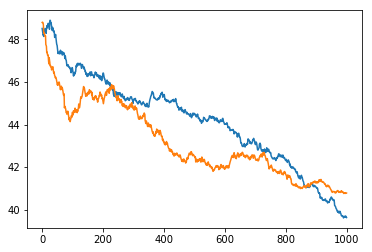

In [448]:
plt.plot(lfa_lambda_0_lc)
plt.plot(lfa_lambda_1_lc)
plt.show()

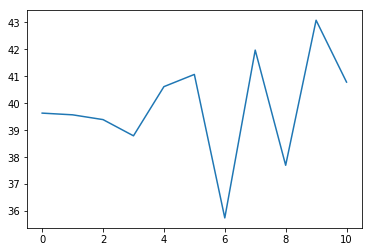

In [449]:
#plot the mean squared errors for lamba vs. MC Q(S,A)
lfa_lambda_mse = []
for i in range(lambda_len):
    lfa_lambda_mse.append(get_lfa_mean_squared_error(lfa_q_dict[i],qsa_dict,action_space,1,21,1,10))

#print(lfa_lambda_mse)
plt.plot(lfa_lambda_mse)
plt.show()

In [ ]:
#get_greedy_action_value_lfa(lfa_q_dict[0],(5,3),action_space)
#test = get_lfa_keys(((19,10),'hit'))
#print(test)

### Part 5 Discussion
Discuss the choice of algorithm used in the previous section.

1. What are the pros and cons of bootstrapping in Easy21? <br> <br>
Bootstrapping allows the model to update the value/action-value function from estimates of other parts of the value function while the Monte Carlo approach updates the value/action-value function at the end of each episode. Bootstrapping, in theory, should have less variance than MC methods do and allows mid-episode information to flow to various states (thus hopefully allowing better exploitation). In Easy21 under the conditions given in the homework, the cons are the addition of another hyperparameter lambda which much be tested for and worse results due to not sufficiently exploring all state spaces.
<br> <br>

2. Would you expect bootstrapping to help more in blackjack or Easy21? Why? <br> <br>
I'd expect bootstrapping to help more in blackjack as the reward is more immediate. In blackjack, unless the player has an Ace, the hand can only increase while in Easy21 the player's hand can wander a bit even if the optimal action is taken at each step. <br> <br>

3. What are the pros and cons of function approximation in Easy21? <br> <br>
In general, function approximation allows you to better explore large state spaces that tabular methods cannot do (as the state is so large to be practically intractable). However in Easy21 the state space is not that large and thus an optimal policy can be converged upon thus function approximation is not as good in this case as in others where the state space is too large to rely on tabular methods. In the conditions given in this homework, function approximation was helpful for Easy21 compared to Sarsa(lambda) as one of the limiters of Sarsa(lambda) in the homework was the failure to sufficiently explore all state space. Function approximation condensed the state space and allowed better exploration.
<br> <br>

4. How would you modify the function approximator suggested in this section to get better results in Easy21? <br> <br>
Tabular updates are a form of function approximator so moving to that specific subset of function approximator would get a better result (ie just do the Monte Carlo method). Could also do something like the DeepMind Atari paper that uses a deep q network and experience replay. The deep q network has more than enough capacity for a problem like this.


In [ ]:
#scrap code
#https://matplotlib.org/examples/mplot3d/surface3d_demo.html

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
#print(X,len(X))
print(np.shape(X))
print(np.shape(np.meshgrid(X,Y)))

X, Y = np.meshgrid(X, Y)
print(np.shape(X))

R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

print(np.shape(X),np.shape(Y),np.shape(Z))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()